In [61]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectFromModel
from xgboost import plot_importance, plot_tree
import pandas as pd
import numpy as np
import xgboost

## Daten einlesen

In [62]:

# Laden des Datensatzes
data_cleaned = "../data/cleaned_train.csv"
data = pd.read_csv(data_cleaned, delimiter=",", encoding="latin", header=0, thousands=",", decimal='.', low_memory=False)

# Definiere die numerischen und kategorischen Features
numerical_features = ['year', 'month', 'day', 'week_of_year', 'lag_1', 'lag_7', 'fourier_sin_365', 'fourier_cos_365',	'days_since_last_holiday',	'days_until_next_holiday']

# Bereits encodierte Features
already_encoded_features = ['Open', 'Promo', 'promo2']

# Noch nicht encodierte kategorische Features
categorical_features_to_encode = ['DayOfWeek', 'StoreType', 'StateHoliday','Assortment', 'Store'] # 'Store' entfernt


## Visualisierung

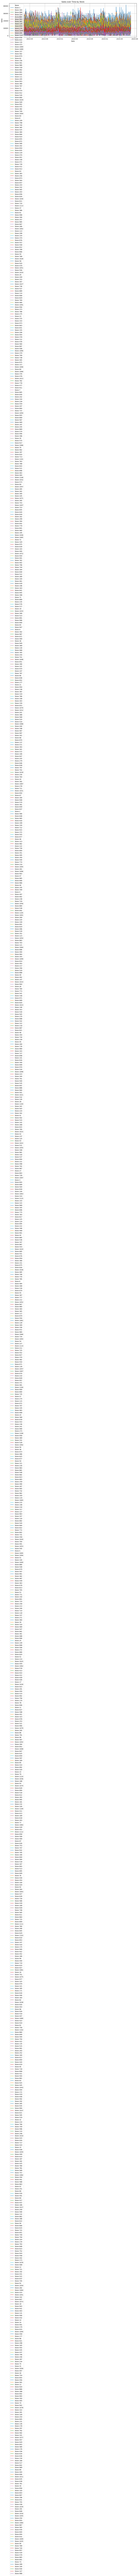

In [535]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming data_cleaned is your DataFrame
# Ensure that data_cleaned is a DataFrame, not a string or another type
if isinstance(data, pd.DataFrame):
    # Convert 'Date' to datetime
    data['Date'] = pd.to_datetime(data['Date'])

    # Plot Sales over time, grouping by Store
    plt.figure(figsize=(15,4))
    for store in data['Store'].unique():
        store_data = data[data['Store'] == store]
        plt.plot(store_data['Date'], store_data['Sales'], label=f'Store {store}')

    plt.title('Sales over Time by Store')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend(title='Store')
    plt.grid(True)
    plt.show()
else:
    print("Error: data_cleaned is not a DataFrame.")

## Split

In [63]:
# Datensatz sortieren, falls nicht bereits geschehen (angenommen, du hast eine Spalte 'Date')
data = data.sort_values('Date')

# Zielvariable und Features definieren
X = data.drop(['Sales', 'Date'], axis=1)  # 'Date' wird entfernt, wenn es keine erklärende Variable ist
y = data['Sales']


# Berechnung der Anzahl der Testdaten (20 % des Datensatzes)
test_size = int(len(data) * 0.2)

# Aufteilen der Daten in Trainings- und Testdaten
X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]

In [340]:
X_train

Store  DayOfWeek  Open  Promo StateHoliday  year  month  day  \
0           1          2     0      0            a  2013      1    1   
275306    304          2     0      0            a  2013      1    1   
898430    986          2     0      0            a  2013      1    1   
658250    724          2     0      0            a  2013      1    1   
732712    805          2     0      0            a  2013      1    1   
...       ...        ...   ...    ...          ...   ...    ...  ...   
940290   1031          5     1      1            0  2015      1   30   
740639    813          5     1      1            0  2015      1   30   
792103    869          5     1      1            0  2015      1   30   
86731      95          5     1      1            0  2015      1   30   
164821    182          5     1      1            0  2015      1   30   

        week_of_year  day_of_week  ...  is_school_holiday  StoreType  \
0                  1            1  ...                  1          c   
275306             1            1  ...                  1          a   
898430             1            1  ...                  1          a   
658250             1            1  ...                  1          d   
732712             1            1  ...                  1          d   
...              ...          ...  ...                ...        ...   
940290             5            4  ...                  0          d   
740639             5            4  ...                  0          a   
792103             5            4  ...                  0          c   
86731              5            4  ...                  0          a   
164821             5            4  ...                  0          d   

        Assortment  promo2 fourier_sin_365 fourier_cos_365  \
0                a       0        0.017213        0.999852   
275306           a       0        0.017213        0.999852   
898430           a       0        0.017213        0.999852   
658250           c       0        0.017213        0.999852   
732712           a       0        0.017213        0.999852   
...            ...     ...             ...             ...   
940290           a       0        0.493776        0.869589   
740639           a       0        0.493776        0.869589   
792103           a       1        0.493776        0.869589   
86731            a       0        0.493776        0.869589   
164821           c       0        0.493776        0.869589   

        days_since_last_holiday  days_until_next_holiday   lag_1   lag_7  
0                             0                      0.0  5140.0  4628.5  
275306                        0                      0.0  8593.5  7490.0  
898430                        0                      0.0  6861.5  6254.5  
658250                        0                      0.0  7497.5  6779.5  
732712                        0                      0.0  7398.0  5698.0  
...                         ...                      ...     ...     ...  
940290                       24                     63.0  5746.0  3588.0  
740639                       24                     63.0  5636.0  5351.0  
792103                       24                     63.0  5714.0  4308.0  
86731                        24                     63.0  7586.0  5050.0  
164821                       24                     63.0  5975.0  4225.0  

[813768 rows x 23 columns]

In [341]:
X_test

Store  DayOfWeek  Open  Promo StateHoliday  year  month  day  \
814917     894          5     1      1            0  2015      1   30   
150301     166          5     1      1            0  2015      1   30   
645799     709          5     1      1            0  2015      1   30   
460623     505          5     1      1            0  2015      1   30   
426299     467          5     1      1            0  2015      1   30   
...        ...        ...   ...    ...          ...   ...    ...  ...   
315075     346          5     1      1            0  2015      7   31   
314133     345          5     1      1            0  2015      7   31   
313375     344          5     1      1            0  2015      7   31   
879015     964          5     1      1            0  2015      7   31   
1017208   1115          5     1      1            0  2015      7   31   

         week_of_year  day_of_week  ...  is_school_holiday  StoreType  \
814917              5            4  ...                  0          a   
150301              5            4  ...                  0          a   
645799              5            4  ...                  0          a   
460623              5            4  ...                  0          a   
426299              5            4  ...                  0          a   
...               ...          ...  ...                ...        ...   
315075             31            4  ...                  1          a   
314133             31            4  ...                  0          a   
313375             31            4  ...                  1          a   
879015             31            4  ...                  1          a   
1017208            31            4  ...                  1          d   

         Assortment  promo2 fourier_sin_365 fourier_cos_365  \
814917            a       0        0.493776        0.869589   
150301            c       1        0.493776        0.869589   
645799            a       0        0.493776        0.869589   
460623            a       0        0.493776        0.869589   
426299            c       0        0.493776        0.869589   
...             ...     ...             ...             ...   
315075            c       0       -0.486273       -0.873807   
314133            a       1       -0.486273       -0.873807   
313375            c       1       -0.486273       -0.873807   
879015            a       0       -0.486273       -0.873807   
1017208           c       0       -0.486273       -0.873807   

         days_since_last_holiday  days_until_next_holiday    lag_1    lag_7  
814917                        24                     63.0   7558.0   6575.0  
150301                        24                     63.0   5408.0   3766.0  
645799                        24                     63.0  10453.0   8120.0  
460623                        24                     63.0   5245.0   4485.0  
426299                        24                     63.0  11073.0  10064.0  
...                          ...                      ...      ...      ...  
315075                        57                     64.0   7781.0   7235.0  
314133                        57                     64.0   5459.0   4052.0  
313375                        57                     64.0  10488.0   7536.0  
879015                        57                     64.0  12407.0   7351.0  
1017208                       57                     64.0   8405.0   5816.0  

[203441 rows x 23 columns]

## Metrik

In [64]:

# Angepasste RMSPE-Funktion, die Tage mit 0 Sales ignoriert
def rmspe(y_true, y_pred):
    # Nur Fälle berücksichtigen, bei denen y_true nicht 0 ist
    mask = y_true != 0
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    
    return np.sqrt(np.mean(((y_true_filtered - y_pred_filtered) / y_true_filtered) ** 2))

In [65]:
# RMSPE als Scorer definieren
rmspe_scorer = make_scorer(rmspe, greater_is_better=False)

## Kreuzvalidierung (TimeSeries)

In [67]:
from sklearn.model_selection import TimeSeriesSplit
# Zeitreihen-Kreuzvalidierung einrichten
tscv = TimeSeriesSplit(n_splits=5)

## Kreuzvalidierung (Blocked TimeSeries)

In [21]:
import numpy as np
from sklearn.model_selection import BaseCrossValidator

class BlockedTimeSeriesSplitByBlock(BaseCrossValidator):
    def __init__(self, n_splits=5, train_size=0.8, test_size=0.2):
        """
        train_size und test_size sind Prozentsätze des jeweiligen Blocks.
        n_splits gibt an, in wie viele Blöcke die Daten aufgeteilt werden.
        """
        self.n_splits = n_splits
        self.train_size = train_size  # Prozentualer Anteil der Trainingsdaten (z.B. 0.8)
        self.test_size = test_size    # Prozentualer Anteil der Testdaten (z.B. 0.2)

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        
        # Größe jedes Blocks berechnen
        block_size = n_samples // self.n_splits

        for i in range(self.n_splits):
            # Definiere die Start- und Endposition des aktuellen Blocks
            block_start = i * block_size
            block_end = block_start + block_size

            # Sub-Blockgröße für Training und Test basierend auf den Prozentsätzen
            train_size_absolute = int(self.train_size * block_size)
            test_size_absolute = block_size - train_size_absolute  # Rest ist Testdaten

            # Trainings- und Testindices im aktuellen Block
            train_indices = np.arange(block_start, block_start + train_size_absolute)
            test_indices = np.arange(block_start + train_size_absolute, block_end)

            yield train_indices, test_indices

In [22]:
blocked_cv_by_block = BlockedTimeSeriesSplitByBlock(n_splits=5, train_size=0.8, test_size=0.2)

## Pre-processing

In [68]:
# Erstelle den Preprocessor für numerische und kategorische Features (ohne Datumsextraktion)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Skalierung für numerische und bereits encodierte Features
        ('enc', 'passthrough', already_encoded_features),  # Bereits encodierte Features durchschleusen (keine weitere Transformation)
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_to_encode)  # Nur noch nicht encodierte Features encodieren
    ])

## Lineare Regression (Base Model)

In [370]:
# Erstelle die Pipeline
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])
pipeline_lr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year', 'month', 'day',
                                                   'week_of_year', 'lag_1',
                                                   'lag_7', 'fourier_sin_365',
                                                   'fourier_cos_365',
                                                   'days_since_last_holiday',
                                                   'days_until_next_holiday']),
                                                 ('enc', 'passthrough',
                                                  ['Open', 'Promo', 'promo2']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['DayOfWeek', 'StoreType',
                                                   'StateHoliday', 'Assortment',
                                                   'Store'])])),
                ('model', LinearRegression())])

In [374]:
# Cross-Validation durchführen
cv_scores = cross_val_score(pipeline_lr, X_train, y_train, cv=tscv, scoring=rmspe_scorer, verbose=True)

In [375]:
mean_rmspe = np.mean(cv_scores)
mean_rmspe

-0.6880055947042327

In [377]:
# Zeitreihen-spezifische Aufteilung
tscv_test = TimeSeriesSplit(n_splits=5)

# Schleife für iteratives Training und Testen
for train_index, test_index in tscv_test.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipeline_lr.fit(X_train, y_train)
    y_pred = pipeline_lr.predict(X_test)

    test_rmspe = rmspe(y_test, y_pred)
    print(f"RMSPE on test split: {test_rmspe}")

RMSPE on test split: 0.6731737276570352
RMSPE on test split: 1.880604961302003
RMSPE on test split: 0.2365155582751194
RMSPE on test split: 0.45447421873366123
RMSPE on test split: 0.23606933491914256


## Gradient Boosting 

In [490]:
# Erstelle die Pipeline
pipeline_gb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(
        n_iter_no_change=10,
        validation_fraction=0.1,
        ))
])

In [463]:
cv_scores = cross_val_score(pipeline_gb, X_train, y_train, cv=tscv, scoring=rmspe_scorer, verbose=True)

In [464]:
pipeline_gb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year', 'month', 'day',
                                                   'week_of_year', 'lag_1',
                                                   'lag_7', 'fourier_sin_365',
                                                   'fourier_cos_365',
                                                   'days_since_last_holiday',
                                                   'days_until_next_holiday']),
                                                 ('enc', 'passthrough',
                                                  ['Open', 'Promo', 'promo2']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['DayOfWeek', 'StoreType',
                                                   'StateHoliday', 'Assortment',
                                                   'Store'])])),
                ('model', GradientBoostingRegressor(n_iter_no_change=10))])

In [465]:
mean_rmspe = np.mean(cv_scores)
mean_rmspe

-0.28085648775965305

In [466]:
# Zeitreihen-spezifische Aufteilung
tscv_test = TimeSeriesSplit(n_splits=5)

# Schleife für iteratives Training und Testen
for train_index, test_index in tscv_test.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipeline_gb.fit(X_train, y_train)
    y_pred = pipeline_gb.predict(X_test)

    test_rmspe = rmspe(y_test, y_pred)
    print(f"RMSPE on test split: {test_rmspe}")

RMSPE on test split: 0.30666240115132953
RMSPE on test split: 0.25132602891198164
RMSPE on test split: 0.2017149016469941
RMSPE on test split: 0.36050446219232934
RMSPE on test split: 0.19244337523905816


In [387]:
# 3. Vorhersagen auf dem Testset machen
y_pred = pipeline_gb.predict(X_test)

test_rmspe = rmspe(y_test, y_pred)
test_rmspe

0.19721065162389786

## XGBoost

In [523]:
import xgboost

pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgboost.XGBRegressor(n_estimators = 272, max_depth= 7, learning_rate= 0.08272492672161898, subsample= 0.8812401504258377, colsample_bytree= 0.5027019175949335, gamma= 5.759774067169282))
])

NameError: name 'cross_val_score' is not defined

In [524]:
pipeline_xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year', 'month', 'day',
                                                   'week_of_year', 'lag_1',
                                                   'lag_7', 'fourier_sin_365',
                                                   'fourier_cos_365',
                                                   'days_since_last_holiday',
                                                   'days_until_next_holiday']),
                                                 ('enc', 'passthrough',
                                                  ['Open', 'Promo', 'promo2']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['DayOfWeek', 'StoreType',...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.08272492672161898, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=7, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=272, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [525]:
cv_scores = cross_val_score(pipeline_xgb, X_train, y_train, cv=tscv, scoring=rmspe_scorer, verbose=True)

In [526]:
cv_scores

array([-0.26506605, -0.18779483, -0.29993949])

In [527]:
mean_rmspe = np.mean(cv_scores)
mean_rmspe

-0.2509334578859422

In [528]:
y_pred = pipeline_xgb.predict(X_test)
test_rmspe = rmspe(y_test, y_pred)
test_rmspe

0.18365498908985528

## Feature Selection XGBoost

In [419]:
# Angenommen, dein 'preprocessor' ist ein ColumnTransformer
preprocessor = pipeline_xgb.named_steps['preprocessor']

# Transformiere die Trainingsdaten, um die Feature-Namen nach der Transformation zu erhalten
X_train_transformed = preprocessor.fit_transform(X_train)

# Falls die Anzahl der Features gleich bleibt:
feature_names = X_train.columns

# Falls die Anzahl der Features verändert wurde, musst du die neuen Feature-Namen entsprechend abrufen:
if hasattr(preprocessor, 'get_feature_names_out'):
    feature_names = preprocessor.get_feature_names_out()

# Feature Importances abrufen
importances = pipeline_xgb.named_steps['model'].feature_importances_

# Features und ihre Wichtigkeit zusammenstellen
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sortieren nach Wichtigkeit
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Ausgabe der Feature Importance
feature_importance_df

Feature  Importance
10           enc__Open    0.521315
4           num__lag_1    0.078152
11          enc__Promo    0.047594
5           num__lag_7    0.023514
19    cat__DayOfWeek_7    0.014385
...                ...         ...
472     cat__Store_442    0.000000
473     cat__Store_443    0.000000
68       cat__Store_38    0.000000
476     cat__Store_446    0.000000
1145   cat__Store_1115    0.000000

[1146 rows x 2 columns]

In [420]:
feature_importance_df[feature_importance_df['Importance'] > 0.0000]

Feature  Importance
10             enc__Open    0.521315
4             num__lag_1    0.078152
11            enc__Promo    0.047594
5             num__lag_7    0.023514
19      cat__DayOfWeek_7    0.014385
..                   ...         ...
704       cat__Store_674    0.000126
79         cat__Store_49    0.000069
71         cat__Store_41    0.000068
978       cat__Store_948    0.000032
26   cat__StateHoliday_b    0.000004

[243 rows x 2 columns]

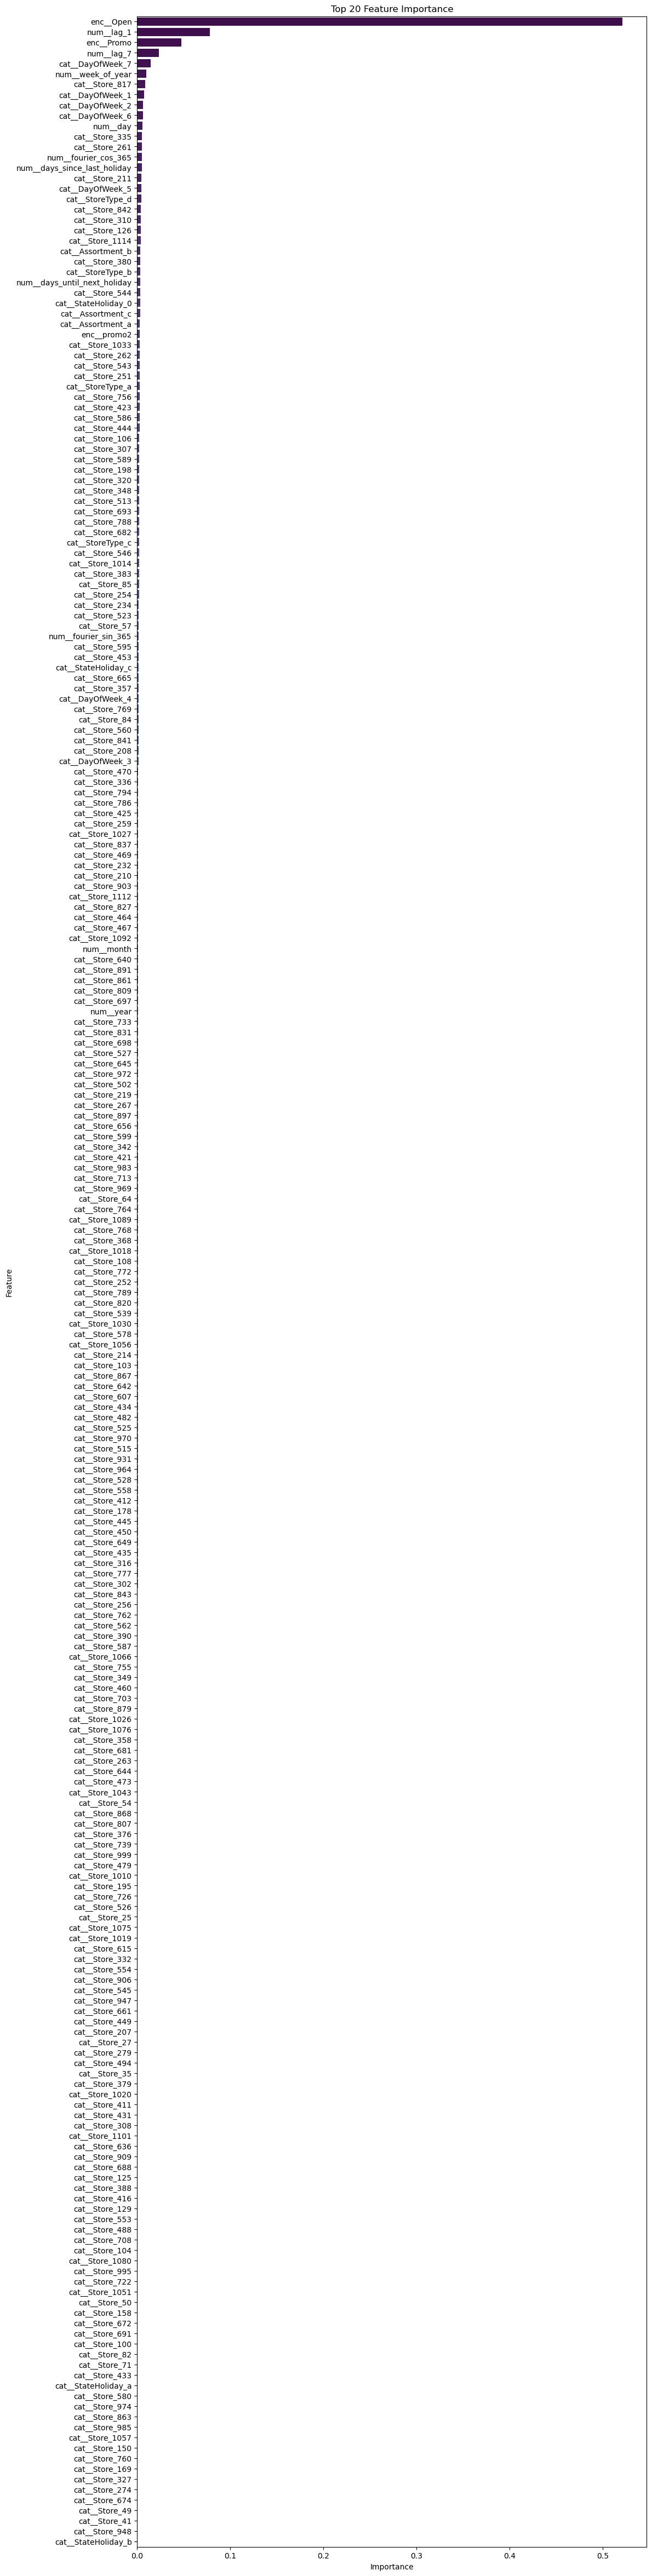

In [450]:
import matplotlib.pyplot as plt
import seaborn as sns

# Anzahl der anzuzeigenden Top-Features
top_n = 30

# Sortiere die DataFrame nach 'Importance' und zeige nur die Top-n Features
feature_importance_df_2 = feature_importance_df.sort_values(by='Importance', ascending=False)[:243]

# Setze die Größe der Abbildung
plt.figure(figsize=(12,60))

# Erstelle das Balkendiagramm
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_2, palette='viridis')

# Füge Titel und Beschriftungen hinzu
plt.title('Top 20 Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')

# Rotieren der y-Achsenbeschriftungen, falls nötig
plt.yticks(rotation=0)

# Zeige das Diagramm an
plt.show()

## Feature Selection

In [ ]:
# Angenommen, dein 'preprocessor' ist ein ColumnTransformer
preprocessor = pipeline_gb.named_steps['preprocessor']

# Transformiere die Trainingsdaten, um die Feature-Namen nach der Transformation zu erhalten
X_train_transformed = preprocessor.fit_transform(X_train)

# Falls die Anzahl der Features gleich bleibt:
feature_names = X_train.columns

# Falls die Anzahl der Features verändert wurde, musst du die neuen Feature-Namen entsprechend abrufen:
if hasattr(preprocessor, 'get_feature_names_out'):
    feature_names = preprocessor.get_feature_names_out()

# Feature Importances abrufen
importances = pipeline_gb.named_steps['model'].feature_importances_

# Features und ihre Wichtigkeit zusammenstellen
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sortieren nach Wichtigkeit
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Ausgabe der Feature Importance
feature_importance_df

In [ ]:
feature_importance_df[feature_importance_df['Importance'] > 0.0000]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Anzahl der anzuzeigenden Top-Features
top_n = 30

# Sortiere die DataFrame nach 'Importance' und zeige nur die Top-n Features
feature_importance_df_2 = feature_importance_df.sort_values(by='Importance', ascending=False)[:30]

# Setze die Größe der Abbildung
plt.figure(figsize=(12, 8))

# Erstelle das Balkendiagramm
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_2, palette='viridis')

# Füge Titel und Beschriftungen hinzu
plt.title('Top 20 Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')

# Rotieren der y-Achsenbeschriftungen, falls nötig
plt.yticks(rotation=0)

# Zeige das Diagramm an
plt.show()

In [ ]:
unwichtige_features = feature_importance_df[feature_importance_df["Importance"] == 0].Feature.tolist()
unwichtige_features

In [ ]:
len(unwichtige_features)

#### Unwichtige Features aussortieren (feature importance = 0)

In [293]:
# Apply the preprocessing pipeline to your data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [ ]:
# Fit a model to determine feature importances
initial_model = GradientBoostingRegressor()
initial_model.fit(X_train_preprocessed, y_train)

In [ ]:
# Select important features
selector = SelectFromModel(estimator=initial_model, threshold= 0.000001, prefit=True)
X_train_selected = selector.transform(X_train_preprocessed)
X_test_selected = selector.transform(X_test_preprocessed)

#### Liste der relevanten Features anzeigen

In [215]:
# Step 3: Get the feature names after preprocessing
# For numerical features
numerical_feature_names = numerical_features

# For already encoded features (they remain the same)
already_encoded_feature_names = already_encoded_features

# For categorical features (get the feature names after one-hot encoding)
categorical_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features_to_encode)

# Combine all feature names
all_feature_names = list(numerical_feature_names) + list(already_encoded_feature_names) + list(categorical_feature_names)

In [193]:
# Step 6: Get the indices of the selected features
selected_feature_indices = selector.get_support(indices=True)

# Step 7: Map the selected features to their names
selected_feature_names = [all_feature_names[i] for i in selected_feature_indices]

# Step 8: Create a DataFrame with feature names and their data types
selected_features_df = pd.DataFrame({
    'Feature': selected_feature_names,
    'Data Type': [X_train_preprocessed.dtype] * len(selected_feature_names)
})

# Display the DataFrame
print(selected_features_df)

           Feature Data Type
0             year   float64
1            month   float64
2              day   float64
3     week_of_year   float64
4            lag_1   float64
5            lag_7   float64
6             Open   float64
7            Promo   float64
8           promo2   float64
9      DayOfWeek_1   float64
10     DayOfWeek_2   float64
11     DayOfWeek_3   float64
12     DayOfWeek_5   float64
13     DayOfWeek_6   float64
14     DayOfWeek_7   float64
15     StoreType_a   float64
16     StoreType_b   float64
17     StoreType_d   float64
18  StateHoliday_0   float64
19  StateHoliday_c   float64
20    Assortment_a   float64
21    Assortment_b   float64
22       Store_251   float64
23       Store_262   float64
24       Store_733   float64
25       Store_756   float64
26       Store_788   float64
27       Store_817   float64
28       Store_842   float64
29      Store_1114   float64


## Pipeline mit FeatureSelection

In [71]:
# Pipeline für die Modellierung
pipeline_gb_fs = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Schritt 1: Vorverarbeitung
    ('feature_selection', SelectFromModel(estimator=xgboost.XGBRegressor(), threshold=0.00000001, prefit=False)),  # Schritt 2: Merkmalsauswahl
    ('model', xgboost.XGBRegressor(n_estimators=250,
    max_depth=8,
    learning_rate=0.07270894723811805,
    subsample=0.7353410114740687,
    colsample_bytree=0.6324177089861035,
    gamma=4.433296674087877))  # Schritt 3: Modellierung
])

In [70]:
# Anpassung und Vorhersage
pipeline_gb_fs.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year', 'month', 'day',
                                                   'week_of_year', 'lag_1',
                                                   'lag_7', 'fourier_sin_365',
                                                   'fourier_cos_365',
                                                   'days_since_last_holiday',
                                                   'days_until_next_holiday']),
                                                 ('enc', 'passthrough',
                                                  ['Open', 'Promo', 'promo2']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['DayOfWeek', 'StoreType',...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.07270894723811805, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=8, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=250, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [423]:
cv_scores_fs = cross_val_score(pipeline_gb_fs, X_train, y_train, cv=tscv, scoring=rmspe_scorer, verbose=True)

In [58]:
cv_scores_fs_block = cross_val_score(pipeline_gb_fs, X_train, y_train, cv=blocked_cv_by_block, scoring=rmspe_scorer, verbose=True) 

In [424]:
mean_rmspe_fs = np.mean(cv_scores_fs)
mean_rmspe_fs

-0.28435114596759514

In [59]:
mean_rmspe_fs = np.mean(cv_scores_fs_block)
mean_rmspe_fs

-0.19106240191147633

In [60]:
y_pred = pipeline_gb_fs.predict(X_test)
test_rmspe = rmspe(y_test, y_pred)
test_rmspe

0.18526804206850825

## Test ChatGPT Lag

In [95]:
import numpy as np

# Angepasste RMSPE-Funktion, die Tage mit 0 Sales ignoriert
def rmspe(y_true, y_pred):
    # Nur Fälle berücksichtigen, bei denen y_true nicht 0 ist
    mask = y_true != 0
    y_true_filtered = y_true[mask]
    
    # Umwandlung von y_pred in ein NumPy-Array, um boolesche Indexierung zu ermöglichen
    y_pred = np.array(y_pred)  # Liste in NumPy-Array umwandeln
    y_pred_filtered = y_pred[mask]
    
    return np.sqrt(np.mean(((y_true_filtered - y_pred_filtered) / y_true_filtered) ** 2))

In [72]:
rmspe_scores = []

In [99]:
# Iterative Vorhersagefunktion (mit Berücksichtigung von Lag- und zusätzlichen Features)
def iterative_forecast(model, X_train, y_train, X_test_preprocessed, forecast_days):
    # Trainiere das Modell mit allen Features
    model.fit(X_train, y_train)
    
    # Vorhersagen auf Basis der Testdaten
    predictions = []
    last_known_sales = list(y_train[-30:])  # Letzte 30 Tage tatsächlicher Sales-Daten
    
    for i in range(forecast_days):
        # Lag-Features für den nächsten Tag berechnen
        lag_1 = last_known_sales[-1]  # Lag-1 ist der zuletzt vorhergesagte Wert
        lag_30 = last_known_sales[-30] if len(last_known_sales) >= 30 else np.nan  # Lag-30 ist 30 Tage zurück
        
        # Hole die transformierten Features für den nächsten Testtag (Lag-Features sind hier schon dabei)
        additional_features = X_test_preprocessed[i].reshape(1, -1)  # Transformierte Features in 2D
        
        # Keine Lag-Features explizit hinzufügen, da sie bereits im Preprocessing enthalten sind
        input_data = additional_features  # Nur die transformierten Features verwenden
        
        # Vorhersage für den nächsten Tag
        next_pred = model.predict(input_data)[0]
        predictions.append(next_pred)
        
        # Update der letzten bekannten Sales-Daten
        last_known_sales.append(next_pred)
    
    return predictions

In [110]:
# Iterative Vorhersagefunktion (mit Berücksichtigung von Lag- und zusätzlichen Features)
def iterative_forecast(pipeline, X_fold_train, y_fold_train, X_fold_val):
    
    # Trainiere das Modell mit allen Features
    pipeline.named_steps['model'].fit(X_fold_train, y_fold_train)
    
    # Vorhersagen auf Basis der Testdaten
    predictions = []
    last_known_sales = list(y_train[-30:])  # Letzte 30 Tage tatsächlicher Sales-Daten
    
    for row in X_fold_val:
        
        # Lag-Features für den nächsten Tag berechnen
        row["lag_1"] = last_known_sales[-1]  # Lag-1 ist der zuletzt vorhergesagte Wert
        row["lag_30"] = last_known_sales[-30] if len(last_known_sales) >= 30 else np.nan  # Lag-30 ist 30 Tage zurück
        
        pipeline.named_steps['preprocessor'].transform(row)
        
        # Vorhersage für den nächsten Tag
        pred = pipeline.named_steps['model'].predict(row)
        predictions.append(pred)
        
        # Update der letzten bekannten Sales-Daten
        last_known_sales.append(pred)
    
    return predictions

In [120]:
# Verbesserte iterative Vorhersagefunktion (mit Berücksichtigung von Lag- und zusätzlichen Features)
def iterative_forecast(pipeline, X_fold_train, y_fold_train, X_fold_val):
    # Trainiere das Modell mit allen Features
    pipeline.named_steps['model'].fit(X_fold_train, y_fold_train)
    
    # Vorhersagen auf Basis der Testdaten
    predictions = []
    last_known_sales = list(y_fold_train[-30:])  # Letzte 30 Tage tatsächlicher Sales-Daten
    
    # Iteriere über die Zeilen von X_fold_val
    for index, row in X_fold_val.iterrows():
        try:
            # Lag-Features für den nächsten Tag berechnen
            row["lag_1"] = last_known_sales[-1]  # Lag-1 ist der zuletzt vorhergesagte Wert
            row["lag_30"] = last_known_sales[-30] if len(last_known_sales) >= 30 else np.nan  # Lag-30 ist 30 Tage zurück
        except IndexError as e:
            print(f"Error in creating lag features for row {index}: {e}")
            row["lag_1"] = np.nan
            row["lag_30"] = np.nan
        
        # Wandeln der Zeile in einen DataFrame, um den Preprocessing-Schritt durchzuführen
        row = row.to_frame().T
        
        # Wende das Preprocessing an
        row_preprocessed = pipeline.named_steps['preprocessor'].transform(row)
        
        # Vorhersage für den nächsten Tag
        pred = pipeline.named_steps['model'].predict(row_preprocessed)
        predictions.append(pred[0])  # pred ist ein Array, daher pred[0]
        
        # Update der letzten bekannten Sales-Daten
        last_known_sales.append(pred[0])
    
    return predictions

# Durchführung der Kreuzvalidierung auf den Trainingsdaten
rmspe_scores = []  # Liste zur Speicherung der RMSPE-Scores

for fold, (train_index, test_index) in enumerate(tscv.split(X_train)):
    print(f"Fold {fold + 1}")
    
    # Train- und Testdaten für diesen Fold
    X_fold_train = X_train.iloc[train_index]
    X_fold_test = X_train.iloc[test_index]
    y_fold_train = y_train.iloc[train_index]
    y_fold_test = y_train.iloc[test_index]
    
    # Preprocessing auf die Train- und Testdaten anwenden
    X_fold_train_preprocessed = pipeline_gb_fs.named_steps['preprocessor'].fit_transform(X_fold_train)
    X_fold_test_preprocessed = pipeline_gb_fs.named_steps['preprocessor'].transform(X_fold_test)
    
    # Iterative Vorhersage über die Testperiode
    y_pred = iterative_forecast(pipeline_gb_fs, X_fold_train_preprocessed, y_fold_train, X_fold_test)
    
    # RMSPE berechnen und speichern
    rmspe_score = rmspe(y_fold_test, y_pred)
    rmspe_scores.append(rmspe_score)
    
    print(f"RMSPE for Fold {fold + 1}: {rmspe_score}")

# Gesamtergebnisse
print(f"Durchschnittliche RMSPE über alle Folds: {np.mean(rmspe_scores)}")

Fold 1
RMSPE for Fold 1: 0.474946864841866
Fold 2
RMSPE for Fold 2: 0.37100443008151396
Fold 3
RMSPE for Fold 3: 0.32661257097286284
Fold 4
RMSPE for Fold 4: 0.2936009666035398
Fold 5
RMSPE for Fold 5: 0.39104734866574126
Durchschnittliche RMSPE über alle Folds: 0.37144243623310474


In [111]:
# Durchführung der Kreuzvalidierung auf den Trainingsdaten
for fold, (train_index, test_index) in enumerate(tscv.split(X_train)):
    print(f"Fold {fold + 1}")
    
    # Train- und Testdaten für diesen Fold
    X_fold_train = X_train.iloc[train_index]
    X_fold_test = X_train.iloc[test_index]
    y_fold_train = y_train.iloc[train_index]
    y_fold_test = y_train.iloc[test_index]
    
    # Preprocessing auf die Train- und Testdaten anwenden
    X_fold_train_preprocessed = pipeline_gb_fs.named_steps['preprocessor'].fit_transform(X_fold_train)
    X_fold_test_preprocessed = pipeline_gb_fs.named_steps['preprocessor'].transform(X_fold_test)
    
    
    # Iterative Vorhersage über die Testperiode
    y_pred = iterative_forecast(pipeline_gb_fs, X_fold_train_preprocessed, y_fold_train, X_fold_test)
    
    # RMSPE berechnen und speichern
    rmspe_score = rmspe(y_fold_test, y_pred)
    rmspe_scores.append(rmspe_score)
    
    print(f"RMSPE for Fold {fold + 1}: {rmspe_score}")

Fold 1


TypeError: 'str' object does not support item assignment

In [97]:
rmspe_scores

[0.22462106290226325,
 0.17938804343249987,
 0.20868198787032732,
 0.17054493156616898,
 0.3560938126230344]

In [98]:
# Durchschnittliche MSE über alle Folds
average_rmspe = np.mean(rmspe_scores)
print(f"\nAverage RMSPE over all folds (Training): {average_rmspe}")


Average RMSPE over all folds (Training): 0.2278659676788588


In [106]:
# Iterative Vorhersagefunktion für den Testdatensatz (ohne manuelle Hinzufügung von Lag-Features)
def iterative_forecast_test(model, X_train, y_train, X_test_preprocessed):
    # Trainiere das Modell mit den Trainingsdaten
    model.fit(X_train, y_train)
    
    # Anzahl der Testtage
    forecast_days = X_test_preprocessed.shape[0]  # Anzahl der Testtage anhand der Zeilenanzahl
    
    # Vorhersagen auf Basis der Testdaten
    predictions = []
    last_known_sales = list(y_train[-30:])  # Letzte 30 Tage tatsächlicher Sales-Daten
    
    for i in range(forecast_days):
        # Hole die transformierten Features für den nächsten Testtag
        additional_features = X_test_preprocessed[i].reshape(1, -1)  # Transformierte Features in 2D
        
        # Keine manuelle Hinzufügung von Lag-Features - Verwende nur die transformierten Features
        input_data = additional_features  # Nur die transformierten Features verwenden
        
        # Vorhersage für den nächsten Tag
        next_pred = model.predict(input_data)[0]
        predictions.append(next_pred)
        
        # Update der letzten bekannten Sales-Daten mit der Vorhersage (dynamische Lag-Feature-Berechnung)
        last_known_sales.append(next_pred)
    
    return predictions

# Preprocessing auf die Trainingsdaten anwenden
X_train_preprocessed = pipeline_gb_fs.named_steps['preprocessor'].fit_transform(X_train)

# Transformiere die Testdaten und wandle das spärliche Array in eine dichte Matrix um
X_test_preprocessed = pipeline_gb_fs.named_steps['preprocessor'].transform(X_test).toarray()

# Iterative Vorhersage für den Testdatensatz (ohne manuelle Hinzufügung von Lag-Features)
y_test_pred = iterative_forecast_test(pipeline_gb_fs.named_steps['model'], X_train_preprocessed, y_train, X_test_preprocessed)

# Berechnung des RMSPE für den Testdatensatz
test_rmspe = rmspe(y_test, y_test_pred)
print(f"\nRMSPE on test data: {test_rmspe}")


RMSPE on test data: 3.876259807793845


In [100]:
# 4. Evaluierung des finalen Modells auf den Validierungsdaten
# Preprocessing auf die gesamten Trainingsdaten anwenden und auf den Validierungsdaten evaluieren
X_train_preprocessed = pipeline_gb_fs.named_steps['preprocessor'].fit_transform(X_train)
X_test_preprocessed = pipeline_gb_fs.named_steps['preprocessor'].transform(X_test)

# Zusätzliche Features extrahieren
additional_features_train = X_train_preprocessed[:, 2:]
additional_features_test = X_test_preprocessed[:, 2:]

# Iterative Vorhersage für den Validierungsdatensatz
forecast_days = int(X_test)  # 20% der Trainingsdatenlänge
y_val_pred = iterative_forecast(pipeline_gb_fs.named_steps['model'], X_train_preprocessed, y_train, X_test_preprocessed, forecast_days, additional_features_train, additional_features_test)

# MSE für den Validierungsdatensatz berechnen
val_mse = rmspe(y_test[:forecast_days], y_val_pred)
print(f"\nMSE on validation data: {val_mse}")

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'DataFrame'

## Hyperparameter Optimierung

### Optuna

In [31]:
import optuna
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.pipeline import Pipeline
import xgboost as xgb

In [467]:
# Optuna-Objective-Funktion
def objective(trial):
    # Hyperparameter-Vorschläge durch Optuna
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 10)
    }
    
    # XGBoost-Modell mit den vorgeschlagenen Parametern
    model = xgb.XGBRegressor(**params)
    
    # Erstelle die Pipeline mit dem Preprocessing und dem Modell
    pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),  # Schritt 1: Vorverarbeitung
            ('feature_selection', SelectFromModel(estimator=xgboost.XGBRegressor(), threshold=0.00000001, prefit=False)),  # Schritt 2: Merkmalsauswahl
            ('model', model)   
    ])
    
    # Cross-Validation Score berechnen
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=tscv, scoring=rmspe_scorer)
    
    # Rückgabe des negativen Durchschnitts, da Optuna standardmäßig minimiert
    return -np.mean(cv_scores)

# Optuna-Studie erstellen und Optimierung starten
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Beste Hyperparameter nach der Optimierung
best_params = study.best_params
print("Beste Hyperparameter: ", best_params)

[I 2024-09-05 14:22:39,503] A new study created in memory with name: no-name-9544f020-55fb-4cdd-bd5c-bfcebda699f0


[I 2024-09-05 14:22:55,175] Trial 0 finished with value: 0.2654673943405536 and parameters: {'n_estimators': 169, 'max_depth': 6, 'learning_rate': 0.06377926187129744, 'subsample': 0.9237093792000572, 'colsample_bytree': 0.608826436732448, 'gamma': 1.0566879148625452}. Best is trial 0 with value: 0.2654673943405536.
[I 2024-09-05 14:23:10,238] Trial 1 finished with value: 0.2709215224123923 and parameters: {'n_estimators': 177, 'max_depth': 5, 'learning_rate': 0.05831281082852016, 'subsample': 0.9788827276536332, 'colsample_bytree': 0.7274715269415326, 'gamma': 6.033864214142774}. Best is trial 0 with value: 0.2654673943405536.
[I 2024-09-05 14:23:32,607] Trial 2 finished with value: 0.2925112637333495 and parameters: {'n_estimators': 275, 'max_depth': 8, 'learning_rate': 0.44586876894152566, 'subsample': 0.5957439973951844, 'colsample_bytree': 0.5752888513990005, 'gamma': 9.13961158562744}. Best is trial 0 with value: 0.2654673943405536.
[I 2024-09-05 14:24:03,784] Trial 3 finished wi

Beste Hyperparameter:  {'n_estimators': 272, 'max_depth': 7, 'learning_rate': 0.08272492672161898, 'subsample': 0.8812401504258377, 'colsample_bytree': 0.5027019175949335, 'gamma': 5.759774067169282}


In [32]:
# Optuna-Objective-Funktion
def objective(trial):
    # Hyperparameter-Vorschläge durch Optuna
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 10)
    }
    
    # XGBoost-Modell mit den vorgeschlagenen Parametern
    model = xgb.XGBRegressor(**params)
    
    # Erstelle die Pipeline mit dem Preprocessing und dem Modell
    pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),  # Schritt 1: Vorverarbeitung
            ('feature_selection', SelectFromModel(estimator=xgboost.XGBRegressor(), threshold=0.00000001, prefit=False)),  # Schritt 2: Merkmalsauswahl
            ('model', model)   
    ])
    
    # Cross-Validation Score berechnen
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=blocked_cv_by_block, scoring=rmspe_scorer)
    
    # Rückgabe des negativen Durchschnitts, da Optuna standardmäßig minimiert
    return -np.mean(cv_scores)

# Optuna-Studie erstellen und Optimierung starten
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Beste Hyperparameter nach der Optimierung
best_params = study.best_params
print("Beste Hyperparameter: ", best_params)

[I 2024-09-09 23:33:35,356] A new study created in memory with name: no-name-9a8fedd5-04d7-402b-9828-b428b6f3c8d1
[I 2024-09-09 23:33:40,783] Trial 0 finished with value: 0.2299760680867709 and parameters: {'n_estimators': 67, 'max_depth': 8, 'learning_rate': 0.025315268467040096, 'subsample': 0.6262941330531727, 'colsample_bytree': 0.9860691329424169, 'gamma': 2.40604431503865}. Best is trial 0 with value: 0.2299760680867709.
[I 2024-09-09 23:33:48,163] Trial 1 finished with value: 0.40207986399026235 and parameters: {'n_estimators': 240, 'max_depth': 5, 'learning_rate': 0.0017518036294037374, 'subsample': 0.8869159578174814, 'colsample_bytree': 0.5606347486414663, 'gamma': 4.356516609633616}. Best is trial 0 with value: 0.2299760680867709.
[I 2024-09-09 23:33:52,710] Trial 2 finished with value: 0.2562247708673496 and parameters: {'n_estimators': 83, 'max_depth': 4, 'learning_rate': 0.6717848668768764, 'subsample': 0.6523147170554089, 'colsample_bytree': 0.693091641230775, 'gamma': 8

Beste Hyperparameter:  {'n_estimators': 250, 'max_depth': 8, 'learning_rate': 0.07270894723811805, 'subsample': 0.7353410114740687, 'colsample_bytree': 0.6324177089861035, 'gamma': 4.433296674087877}


#### RandomizesGridSearch

In [539]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
import numpy as np

# Definiere die Hyperparameter-Verteilungen, die getestet werden sollen
param_distributions = {
    'model__n_estimators': [50, 100, 150, 200, 250, 300],
    'model__max_depth': [3, 4, 5, 6, 7, 8],
    'model__learning_rate': np.logspace(-3, 0, num=100),  # Logarithmische Verteilung für den Lernrate
    'model__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'model__gamma': [0, 1, 2, 3, 4, 5, 10]
}

# XGBoost-Modell initialisieren
model = xgb.XGBRegressor()

# Erstelle die Pipeline mit dem Preprocessing und dem Modell
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Schritt 1: Vorverarbeitung
    ('feature_selection', SelectFromModel(estimator=xgb.XGBRegressor(), threshold=0.00000001, prefit=False)),  # Schritt 2: Merkmalsauswahl
    ('model', model)   # Schritt 3: Modell
])

# Definiere die RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,  # Die gesamte Pipeline als Schätzer
    param_distributions=param_distributions,  # Hyperparameter-Verteilungen
    n_iter=50,  # Anzahl der Iterationen (wie viele zufällige Kombinationen getestet werden)
    cv=tscv,  # TimeSeriesSplit für zeitabhängige Daten
    scoring=rmspe_scorer,  # Der benutzerdefinierte Scorer
    n_jobs=-1,  # Parallele Jobs (so viele wie möglich)
    verbose=2,  # Ausgabe von Zwischenergebnissen
    random_state=42  # Setze einen festen Seed für Reproduzierbarkeit
)

# Starte die RandomizedSearch-Optimierung
random_search.fit(X_train, y_train)

# Beste Hyperparameter nach der Optimierung
best_params = random_search.best_params_
print("Beste Hyperparameter: ", best_params)

# Ergebnis des besten Modells
best_score = random_search.best_score_
print("Bester Score: ", best_score)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END model__colsample_bytree=0.9, model__gamma=3, model__learning_rate=0.0016297508346206436, model__max_depth=4, model__n_estimators=100, model__subsample=0.6; total time=   6.8s
[CV] END model__colsample_bytree=0.9, model__gamma=3, model__learning_rate=0.0016297508346206436, model__max_depth=4, model__n_estimators=100, model__subsample=0.6; total time=   9.8s
[CV] END model__colsample_bytree=0.5, model__gamma=5, model__learning_rate=0.08697490026177834, model__max_depth=6, model__n_estimators=250, model__subsample=0.7; total time=  10.6s
[CV] END model__colsample_bytree=0.9, model__gamma=3, model__learning_rate=0.0016297508346206436, model__max_depth=4, model__n_estimators=100, model__subsample=0.6; total time=  15.8s
[CV] END model__colsample_bytree=0.5, model__gamma=5, model__learning_rate=0.08697490026177834, model__max_depth=6, model__n_estimators=250, model__subsample=0.7; total time=  18.2s
[CV] END model__colsam

### Optuna 2

In [224]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 1.0, log=True),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
    }
    model = GradientBoostingRegressor(n_iter_no_change=5, **params)
    cv_scores = cross_val_score(model, X_train_selected, y_train, cv=5, scoring=rmspe_scorer)
    return -np.mean(cv_scores)

study2 = optuna.create_study(direction='minimize')
study2.optimize(objective, n_trials=50)
best_params = study2.best_params

[I 2024-08-30 23:42:13,069] A new study created in memory with name: no-name-c76b5a9c-5cbf-4403-a923-ed319070bb84
[I 2024-08-31 00:01:08,925] Trial 0 finished with value: 0.21275163750250298 and parameters: {'n_estimators': 107, 'max_depth': 7, 'learning_rate': 0.44300679502587403, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.21275163750250298.
[I 2024-08-31 00:19:42,129] Trial 1 finished with value: 0.3432867450899385 and parameters: {'n_estimators': 163, 'max_depth': 5, 'learning_rate': 0.007669382805689857, 'min_samples_split': 3, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.21275163750250298.
[I 2024-08-31 00:42:12,425] Trial 2 finished with value: 0.26731454564087925 and parameters: {'n_estimators': 154, 'max_depth': 6, 'learning_rate': 0.018388625486154716, 'min_samples_split': 9, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.21275163750250298.
[I 2024-08-31 00:54:58,735] Trial 3 finished with value: 0.24186243511078778 and parame

Bestes Ergebnis: GradientBoostingRegressor ( n_estimators= 237, max_depth = 8, learning_rate = 0.22484530035059536, min_samples_split = 5, min_samples_leaf = 7)

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
import numpy as np

# Definiere die Hyperparameter-Raster, die getestet werden sollen
param_grid = {
    'model__n_estimators': [50, 150, 300],  # Weniger Werte für die Anzahl der Bäume
    'model__max_depth': [3, 5, 7],  # Reduzierte Tiefe
    'model__learning_rate': [0.01, 0.1, 0.3],  # Wichtige Zwischenwerte
    'model__subsample': [0.6, 0.8, 1.0],  # Repräsentative Auswahl
    'model__colsample_bytree': [0.6, 0.8, 1.0],  # Repräsentative Auswahl für Kolumnen-Stichprobe
    'model__gamma': [0, 2, 5]  # Weniger Werte für Gamma
}

# XGBoost-Modell initialisieren
model = xgb.XGBRegressor()

# Erstelle die Pipeline mit dem Preprocessing und dem Modell
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Schritt 1: Vorverarbeitung
    ('feature_selection', SelectFromModel(estimator=xgb.XGBRegressor(), threshold=0.00000001, prefit=False)),  # Schritt 2: Merkmalsauswahl
    ('model', model)   # Schritt 3: Modell
])

# Definiere die GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,  # Die gesamte Pipeline als Schätzer
    param_grid=param_grid,  # Hyperparameter-Raster
    cv=tscv,  # TimeSeriesSplit für zeitabhängige Daten
    scoring=rmspe_scorer,  # Der benutzerdefinierte Scorer
    n_jobs=-1,  # Parallele Jobs (so viele wie möglich)
    verbose=2  # Ausgabe von Zwischenergebnissen
)

# Starte die GridSearch-Optimierung
grid_search.fit(X_train, y_train)

# Beste Hyperparameter nach der Optimierung
best_params = grid_search.best_params_
print("Beste Hyperparameter: ", best_params)

# Ergebnis des besten Modells
best_score = grid_search.best_score_
print("Bester Score: ", best_score)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
[CV] END model__colsample_bytree=0.6, model__gamma=0, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50, model__subsample=0.8; total time=   4.1s
[CV] END model__colsample_bytree=0.6, model__gamma=0, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50, model__subsample=0.6; total time=   4.2s
[CV] END model__colsample_bytree=0.6, model__gamma=0, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50, model__subsample=0.8; total time=   7.1s
[CV] END model__colsample_bytree=0.6, model__gamma=0, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50, model__subsample=0.6; total time=   7.3s
[CV] END model__colsample_bytree=0.6, model__gamma=0, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50, model__subsample=0.8; total time=   9.7s
[CV] END model__colsample_bytree=0.6, model__gamma=0, model__learning_rate=0.01, model__max_depth=3, model

## Hyperparameter Optimierung

In [ ]:
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [3, 4, 5],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__subsample': [0.8, 0.9, 1.0]
}

In [19]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    estimator=pipeline_gb,
    param_distributions=param_grid,
    n_iter=50,  # Reduziert die Anzahl der getesteten Kombinationen
    cv=5,
    n_jobs=-1,
    scoring=rmspe_scorer,
    verbose=2
)

random_search.fit(X_train, y_train)

print("Beste Parameter:", random_search.best_params_)
print("Bestes Ergebnis:", random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END model__learning_rate=0.1, model__max_depth=3, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100, model__subsample=0.8; total time= 3.8min
[CV] END model__learning_rate=0.1, model__max_depth=3, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100, model__subsample=0.8; total time= 3.9min
[CV] END model__learning_rate=0.1, model__max_depth=3, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100, model__subsample=0.8; total time= 3.9min
[CV] END model__learning_rate=0.1, model__max_depth=3, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100, model__subsample=0.8; total time= 3.9min
[CV] END model__learning_rate=0.1, model__max_depth=3, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100, model__subsample=0.8; total time= 3.9min
[CV] END model__learning_rate=0.05, model__max_depth=3, mo

## Evaluation auf den Testdaten

In [358]:
# 3. Vorhersagen auf dem Testset machen
y_pred = pipeline_gb.predict(X_test)

test_rmspe = rmspe(y_test, y_pred)
test_rmspe

0.22528485716526342

## Verteilung Test- und Trainingsdaten

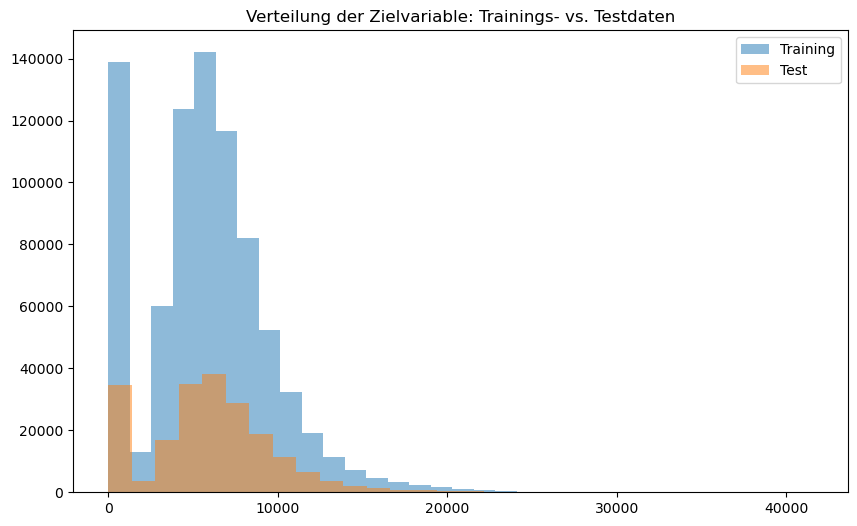

In [365]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.hist(y_train, bins=30, alpha=0.5, label='Training')
plt.hist(y_test, bins=30, alpha=0.5, label='Test')
plt.legend()
plt.title('Verteilung der Zielvariable: Trainings- vs. Testdaten')
plt.show()